<a href="https://colab.research.google.com/github/ldtownsend/DS-Unit-2-Regression-Classification/blob/master/LT_DS7_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do exploratory visualizations with Seaborn.
- [X] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
mask = df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS' #and (df['SALE_PRICE'] > 100000 and df['SALE_PRICE'] < 2000000)
df = df[mask]

In [0]:
mask2 = df['SALE_PRICE'] > 100000
df = df[mask2]

In [6]:
mask3 = df['SALE_PRICE'] < 2000000 
df = df[mask3]
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [0]:
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].str.replace(',', '')
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].astype(str).astype(int)

In [8]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['SALE_DATE'].describe(), df.shape

(count                    3151
 unique                     91
 top       2019-01-31 00:00:00
 freq                       78
 first     2019-01-01 00:00:00
 last      2019-04-30 00:00:00
 Name: SALE_DATE, dtype: object, (3151, 21))

In [9]:
train = df[df.SALE_DATE.dt.month < 4]
test  = df[df.SALE_DATE.dt.month == 4]
train.shape, test.shape

((2507, 21), (644, 21))

In [10]:
train['EASE-MENT'].isnull().sum()
# The entire EASE-MENT column is NaNs, so we can drop it.

2507

In [0]:
train = train.drop(columns=['EASE-MENT'])
test = test.drop(columns=['EASE-MENT'])

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
for col in sorted(train.columns):
  if train[col].nunique() <= 20:
    print(col)

APARTMENT_NUMBER
BOROUGH
BUILDING_CLASS_AT_PRESENT
BUILDING_CLASS_AT_TIME_OF_SALE
BUILDING_CLASS_CATEGORY
COMMERCIAL_UNITS
RESIDENTIAL_UNITS
TAX_CLASS_AT_PRESENT
TAX_CLASS_AT_TIME_OF_SALE
TOTAL_UNITS


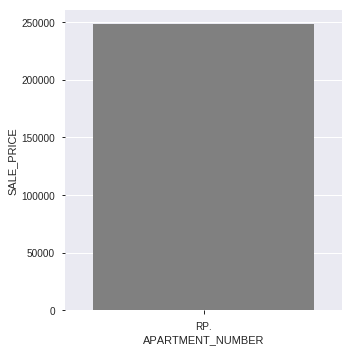

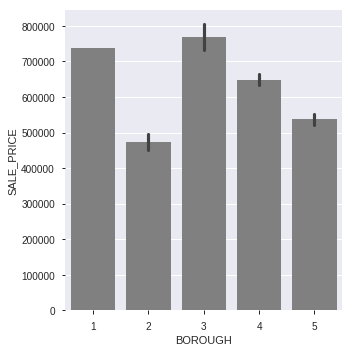

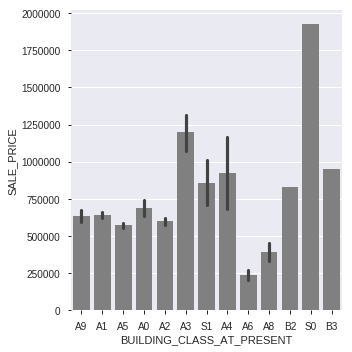

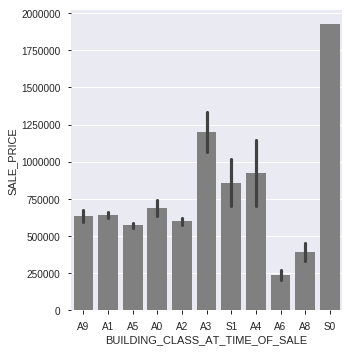

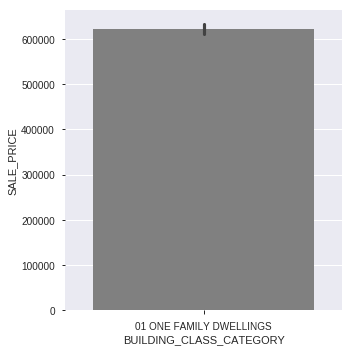

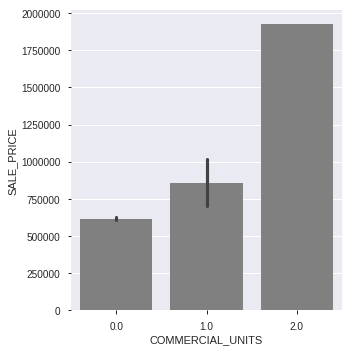

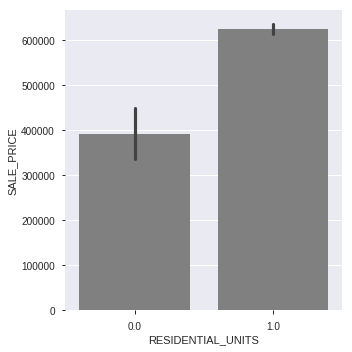

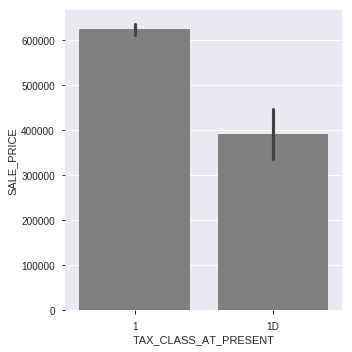

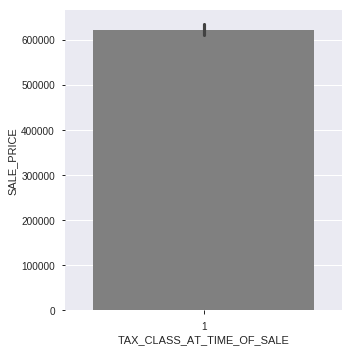

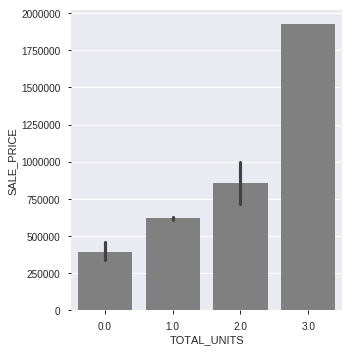

In [14]:
for col in sorted(train.columns):
  if train[col].nunique() <= 20:
#     print(col)
    sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar', color='grey', );
    plt.show()

In [15]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaN,NaN
APARTMENT_NUMBER,1,1,RP.,1,NaN,NaN
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaN,NaN
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01 00:00:00,2019-03-30 00:00:00
NEIGHBORHOOD,2507,176,FLUSHING-NORTH,77,NaN,NaN
ADDRESS,2507,2497,104-18 187TH STREET,2,NaN,NaN


So with this, we know that we can drop APARTMENT_NUMBER and probably for TAX_CLASS_AT_PRESENT

I'll need to get LAND_SQUARE_FEET to a numeric.

We know we need to do one-hot encoding on the two building class features...

In [16]:
train.dtypes

BOROUGH                                    int64
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
APARTMENT_NUMBER                          object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                           int64
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE                         datetime64[ns]
dtype: object

In [17]:
train['ZIP_CODE'].value_counts(normalize=True)

10312.0    0.045872
10306.0    0.045074
10314.0    0.037894
11434.0    0.030714
11413.0    0.027523
11234.0    0.026326
11412.0    0.025927
10304.0    0.024332
10305.0    0.021939
10465.0    0.020742
11229.0    0.019545
11420.0    0.019545
10308.0    0.018349
10309.0    0.018349
10469.0    0.017551
11357.0    0.016753
11411.0    0.016354
10303.0    0.015955
11236.0    0.014360
11429.0    0.014360
11422.0    0.014360
10466.0    0.013961
11414.0    0.013562
11365.0    0.013562
11436.0    0.013163
11433.0    0.011966
10302.0    0.011568
11203.0    0.011568
11364.0    0.011169
11358.0    0.010770
             ...   
11104.0    0.002393
11001.0    0.002393
11224.0    0.002393
11225.0    0.002393
11368.0    0.001994
10452.0    0.001994
10472.0    0.001994
11213.0    0.001596
10460.0    0.001197
11226.0    0.001197
10458.0    0.001197
11221.0    0.001197
11415.0    0.001197
11416.0    0.001197
10470.0    0.001197
11233.0    0.000798
10475.0    0.000798
10454.0    0.000798
11232.0    0.000798


In [18]:
train['BUILDING_CLASS_AT_TIME_OF_SALE'].value_counts(normalize=True)

A1    0.366574
A5    0.310730
A2    0.164739
A9    0.076984
A0    0.026725
S1    0.015556
A3    0.015158
A8    0.012365
A6    0.005584
A4    0.005185
S0    0.000399
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: float64

In [19]:
train['BUILDING_CLASS_AT_PRESENT'].value_counts(normalize=True)

A1    0.366574
A5    0.310730
A2    0.163941
A9    0.076984
A0    0.026725
S1    0.015556
A3    0.015158
A8    0.012365
A6    0.005584
A4    0.005185
S0    0.000399
B2    0.000399
B3    0.000399
Name: BUILDING_CLASS_AT_PRESENT, dtype: float64

From the solutions manual circulated before the assignment.

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
train['BOROUGH'] = train['BOROUGH'].astype(str)
test['BOROUGH'] = test['BOROUGH'].astype(str)

# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [21]:
train['NEIGHBORHOOD'].head()

44              OTHER
61     QUEENS VILLAGE
78              OTHER
108             OTHER
111             OTHER
Name: NEIGHBORHOOD, dtype: object

In [0]:
# On second though, after looking at the value_counts normalized of these two they are extremely similar. 
# I'll only do it for AT_PRESENT. I'm concerned that having both could be an issue at some point down the line.

import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(train['BUILDING_CLASS_AT_PRESENT'])
X_train_encoded = encoder.fit_transform(train)
X_test_encoded = encoder.transform(test)

In [0]:
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(X_train_encoded['NEIGHBORHOOD'])
X_train_encoded1 = encoder.fit_transform(X_train_encoded)
X_test_encoded1 = encoder.transform(X_test_encoded)

In [24]:
X_train_encoded1.dtypes

BOROUGH                                          object
NEIGHBORHOOD_OTHER                                int64
NEIGHBORHOOD_QUEENS VILLAGE                       int64
NEIGHBORHOOD_BAYSIDE                              int64
NEIGHBORHOOD_FLUSHING-NORTH                       int64
NEIGHBORHOOD_LAURELTON                            int64
NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK             int64
NEIGHBORHOOD_SPRINGFIELD GARDENS                  int64
NEIGHBORHOOD_GREAT KILLS                          int64
NEIGHBORHOOD_SOUTH OZONE PARK                     int64
NEIGHBORHOOD_MIDLAND BEACH                        int64
NEIGHBORHOOD_ST. ALBANS                           int64
BUILDING_CLASS_CATEGORY                          object
TAX_CLASS_AT_PRESENT                             object
BLOCK                                             int64
LOT                                               int64
BUILDING_CLASS_AT_PRESENT_A9                      int64
BUILDING_CLASS_AT_PRESENT_A1                    

In [0]:
# Setting the names of targets/features, dropping those with high cardinality and redundancy.
# ZIP_CODE, ADDRESS, 
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'ZIP_CODE', 'BUILDING_CLASS_CATEGORY', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'TAX_CLASS_AT_PRESENT', 'APARTMENT_NUMBER', 'SALE_DATE'] # Consider adding sell date?
features = X_train_encoded1.columns.drop([target] + high_cardinality)

X_train = X_train_encoded1[features]
y_train = X_train_encoded1[target]

X_test = X_test_encoded1[features]
y_test = X_test_encoded1[target]

In [0]:
# X_train.APARTMENT_NUMBER.value_counts()

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=6)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

model = LinearRegression()
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f} \n')

Test MAE: $172,889 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
